In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import os

from classifier_model_cifar import Model_A,Model_B,Model_C,Model_D
from model import CNN
from torchsummary import summary
import copy

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 128
total_epoch = 100

In [4]:
transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

train_indices, val_indices = train_test_split(np.arange(len(trainset)), test_size=0.2)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=2,
    sampler=train_sampler
)

val_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=2,
    sampler=valid_sampler
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_size = len(train_sampler)
val_size = len(valid_sampler)

In [8]:
print('length trainset : {}, testset : {}'.format(len(trainset), len(testset)))

length trainset : 50000, testset : 10000


#### Display Random Batch of 4 Training Images




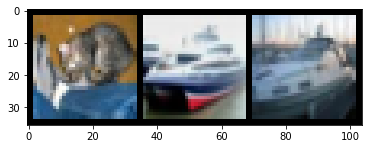

       cat       ship       ship


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:3]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(3)))

In [31]:
# Send the model to GPU
model = Model_D()

In [32]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
summary(model, input_size = (3,32,32), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         614,600
              ReLU-2                  [-1, 200]               0
           Dropout-3                  [-1, 200]               0
            Linear-4                  [-1, 200]          40,200
              ReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
           Softmax-7                   [-1, 10]               0
Total params: 656,810
Trainable params: 656,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 2.51
Estimated Total Size (MB): 2.53
----------------------------------------------------------------


In [35]:
model = model.to(device)

In [36]:
model_folder = os.path.abspath('./checkpoints')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_path = os.path.join(model_folder, 'cifar10_Model_A.pth')

### training

In [37]:
model.train()  # Set model to training mode

train_loss = []
train_acc = []
val_loss = []
val_acc = []

best_acc = 0.0

for epoch in range(total_epoch):

    model.train()  # Set model to training mode
    
    running_loss = 0.0
    running_corrects = 0.0
    epoch_size = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        _, preds = torch.max(outputs, 1)

        optimizer.step()

        # print statistics
        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        epoch_size += inputs.size(0)
        
    # Normalizing the loss by the total number of train batches
    
    running_loss /= epoch_size
    running_corrects =  running_corrects.double() / epoch_size
    
    train_loss.append(running_loss)
    train_acc.append(running_corrects)
    
    print('train Loss: {:.4f} Acc: {:.4f}'.format(running_loss, running_corrects))
    
    # evalute
    print('Finished epoch {}, starting evaluation'.format(epoch+1))

    model.eval()   # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0.0
    epoch_size = 0.0
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            
            epoch_size += inputs.size(0)
    
    running_loss /= epoch_size
    running_corrects =  running_corrects.double() / epoch_size
    
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(running_loss, running_corrects))
    
    val_loss.append(running_loss)
    val_acc.append(running_corrects)
    
    # deep copy the model
    if running_corrects > best_acc:
        print("saving best model val_acc : {:.4f}".format(running_corrects))
        best_acc = running_corrects
        
        model_copy = copy.deepcopy(model)
        model_copy = model_copy.cpu()
        
        model_state_dict = model_copy.state_dict()
        torch.save(model_state_dict, model_path)

        del model_copy

print('==> Finished Training ...')

train Loss: 0.0173 Acc: 0.2346
Finished epoch 1, starting evaluation
Validation Loss: 0.0171 Acc: 0.2825
saving best model val_acc : 0.2825
train Loss: 0.0169 Acc: 0.2966
Finished epoch 2, starting evaluation
Validation Loss: 0.0168 Acc: 0.3341
saving best model val_acc : 0.3341
train Loss: 0.0168 Acc: 0.3089
Finished epoch 3, starting evaluation
Validation Loss: 0.0166 Acc: 0.3510
saving best model val_acc : 0.3510
train Loss: 0.0167 Acc: 0.3105
Finished epoch 4, starting evaluation
Validation Loss: 0.0167 Acc: 0.3400
train Loss: 0.0167 Acc: 0.3181
Finished epoch 5, starting evaluation
Validation Loss: 0.0167 Acc: 0.3336
train Loss: 0.0166 Acc: 0.3258
Finished epoch 6, starting evaluation
Validation Loss: 0.0166 Acc: 0.3478
train Loss: 0.0166 Acc: 0.3258
Finished epoch 7, starting evaluation
Validation Loss: 0.0166 Acc: 0.3517
saving best model val_acc : 0.3517
train Loss: 0.0166 Acc: 0.3280
Finished epoch 8, starting evaluation
Validation Loss: 0.0166 Acc: 0.3557
saving best model va

Validation Loss: 0.0162 Acc: 0.4055
train Loss: 0.0162 Acc: 0.3881
Finished epoch 73, starting evaluation
Validation Loss: 0.0162 Acc: 0.4073
train Loss: 0.0161 Acc: 0.3927
Finished epoch 74, starting evaluation
Validation Loss: 0.0161 Acc: 0.4133
train Loss: 0.0162 Acc: 0.3908
Finished epoch 75, starting evaluation
Validation Loss: 0.0162 Acc: 0.4043
train Loss: 0.0162 Acc: 0.3884
Finished epoch 76, starting evaluation
Validation Loss: 0.0163 Acc: 0.3977
train Loss: 0.0161 Acc: 0.3949
Finished epoch 77, starting evaluation
Validation Loss: 0.0162 Acc: 0.4089
train Loss: 0.0162 Acc: 0.3890
Finished epoch 78, starting evaluation
Validation Loss: 0.0162 Acc: 0.4009
train Loss: 0.0162 Acc: 0.3894
Finished epoch 79, starting evaluation
Validation Loss: 0.0162 Acc: 0.4005
train Loss: 0.0162 Acc: 0.3878
Finished epoch 80, starting evaluation
Validation Loss: 0.0163 Acc: 0.3926
train Loss: 0.0162 Acc: 0.3905
Finished epoch 81, starting evaluation
Validation Loss: 0.0162 Acc: 0.4050
train Loss

### loss

[0.01612786285877228, 0.01584840703010559, 0.015620335042476653, 0.015506132030487061, 0.0153063791513443, 0.015164103400707245, 0.015277315735816956, 0.015062624645233154, 0.01495875676870346, 0.014922547101974487, 0.014925753319263458, 0.014847079288959503, 0.014835211312770843, 0.014668455922603607, 0.01459303867816925, 0.014586022782325745, 0.014602713286876678, 0.014546857941150666, 0.014526236712932586, 0.014455768811702728, 0.01445046147108078, 0.014419679164886474, 0.014432486855983735, 0.014327947020530701, 0.014309637200832366, 0.014316276490688324, 0.014357383716106415, 0.014293607056140899, 0.014263372921943665, 0.014251754093170166, 0.014275675106048585, 0.014273561477661133, 0.014219607162475585, 0.014224200975894928, 0.014219300282001496, 0.014156014680862427, 0.014170466673374175, 0.014164406716823577, 0.014118044364452362, 0.014168409538269044, 0.014099330472946167, 0.014167679154872895, 0.014073473381996155, 0.01405773993730545, 0.014086351323127747, 0.014185865628719

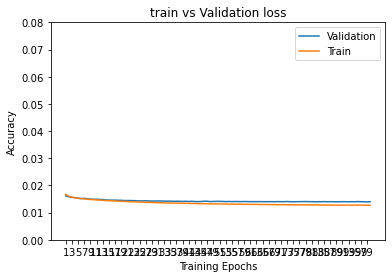

In [18]:
hist = [h for h in val_loss]
hist2 = [h for h in train_loss]
print(hist)
plt.title("train vs Validation loss")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(val_loss)+1),hist,label="Validation")
plt.plot(range(1,len(train_loss)+1),hist2,label="Train")
plt.ylim((0,0.08))
plt.xticks(np.arange(1, len(train_loss)+1, 2))
plt.legend()
plt.show()

### accuracy 

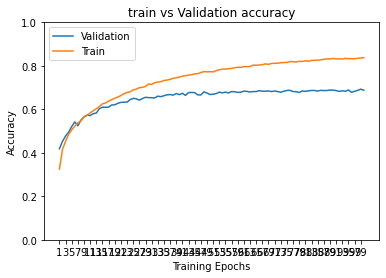

In [19]:
hist = [h.cpu() for h in val_acc]
hist2 = [h.cpu() for h in train_acc]

plt.title("train vs Validation accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(val_acc)+1),hist,label="Validation")
plt.plot(range(1,len(train_acc)+1),hist2,label="Train")
plt.ylim((0,1.0))
plt.xticks(np.arange(1, len(train_acc)+1, 2))
plt.legend()
plt.show()